Specs for the notebook:
- ideally takes any huggingface model but llama of some sort is good
- produces the difference vectors
- produces intervened vectors for entities/attributes
- produces the corresponding native vectors for the entities/attributes

In [9]:
import torch
import random
import gc
import dataclasses
import tqdm
import os

import pandas as pd
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForCausalLM

def load_model_and_tokenizer(gpu_num, model_name="meta-llama/Llama-2-7b-chat-hf"):
    device = torch.device(f"cuda:{gpu_num}")
    model = AutoModelForCausalLM.from_pretrained(
        model_name, cache_dir="/data2/sjeromeh/cache/pretrained_models"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="/data2/sjeromeh/cache/pretrained_models")
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model.eval()
    return model, tokenizer


def clear_hooks(input_hooks):
    for hook in input_hooks:
        hook.remove()
    input_hooks = []
    gc.collect()

Load model and tokenizer

In [2]:
model_name = "EleutherAI/pythia-6.9b"
model_alias = "pythia-7b"

model, tokenizer = load_model_and_tokenizer(0, model_name=model_name)
device = model.device

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]
/home/sjeromeh/anaconda3/envs/generalize/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Load data

In [3]:
countries_df = pd.read_csv("data/countries.csv")
names_df = pd.read_csv("data/names.csv", index_col=0)

countries_to_capitals = countries_df.set_index("country")["capital"].to_dict()
names = names_df["name"].tolist()

# Keep only single token countries and names
countries_to_capitals = {k: v for k, v in countries_to_capitals.items() if len(tokenizer.encode(k, add_special_tokens=False)) == 1}
names = [n for n in names if len(tokenizer.encode(n, add_special_tokens=False)) == 1]

print(f"Number of countries: {len(countries_to_capitals)}, Sample: {list(countries_to_capitals.items())[:5]}")
print(f"Number of names: {len(names)}, Sample: {names[:5]}")

Number of countries: 14, Sample: [('Australia', 'Canberra'), ('Brazil', 'Brasília'), ('Canada', 'Ottawa'), ('China', 'Beijing'), ('France', 'Paris')]
Number of names: 41, Sample: ['Michael', 'James', 'John', 'Robert', 'David']


Prompt generation

In [4]:
@dataclasses.dataclass(frozen=True)
class Prompt:
    context: str
    questions: list[str]
    answers: list[str]
    names: list[str]
    countries: list[str]


def generate_prompt_pair(num_entities):
    cs = random.sample(list(countries_to_capitals.keys()), num_entities*2)
    ns = random.sample(names, num_entities*2)

    cs_1 = cs[:num_entities]
    ns_1 = ns[:num_entities]
    cs_2 = cs[num_entities:]
    ns_2 = ns[num_entities:]

    es_1 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_1, ns_1)]
    es_2 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_2, ns_2)]
    target_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_1)}"
    source_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_2)}"
    target_questions = [f"Question: Which city does {n} live in?" for n in ns_1]
    source_questions = [f"Question: Which city does {n} live in?" for n in ns_2]
    target_answers = [countries_to_capitals[c] for c in cs_1]
    source_answers = [countries_to_capitals[c] for c in cs_2]
    return (Prompt(
        context=target_context,
        questions=target_questions,
        answers=target_answers,
        names=ns_1,
        countries=cs_1,
    ), Prompt(
        context=source_context,
        questions=source_questions,
        answers=source_answers,
        names=ns_2,
        countries=cs_2,
    ))

target_prompt, source_prompt = generate_prompt_pair(2)
print(target_prompt)
print(source_prompt)

Prompt(context='Answer the question based on the context below. Keep the answer short.\n\nContext: Stephen lives in the capital city of Mexico. Adam lives in the capital city of China.', questions=['Question: Which city does Stephen live in?', 'Question: Which city does Adam live in?'], answers=['Mexico City', 'Beijing'], names=['Stephen', 'Adam'], countries=['Mexico', 'China'])
Prompt(context='Answer the question based on the context below. Keep the answer short.\n\nContext: Elizabeth lives in the capital city of Iran. Maria lives in the capital city of Spain.', questions=['Question: Which city does Elizabeth live in?', 'Question: Which city does Maria live in?'], answers=['Tehran', 'Madrid'], names=['Elizabeth', 'Maria'], countries=['Iran', 'Spain'])


Patching experiment

In [7]:
def save_outputs(layer: int, save_map: dict):
    """Hook function for saving the output of a model component"""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        save_map[layer] = proj_output.clone()
        return output
    return hook_fn


def save_hidden_states(ids, model):
    """Save the hidden states of a model. Returns model output and a (num_layers,num_tokens,hidden_size) tensor of hidden states."""
    hooks = []
    hidden_states = {}
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer in range(len(model_layers)):
        if "pythia" in model_name:
            hidden_state = model_layers[layer].mlp
        else:
            hidden_state = model_layers[layer].post_attention_layernorm
        hidden_state_hook_handle = hidden_state.register_forward_hook(save_outputs(layer, hidden_states))
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
        )
    clear_hooks(hooks)
    hidden_states_tensor = torch.stack([hidden_states[i] for i in range(len(hidden_states))], dim=0).squeeze(1)
    return out, hidden_states_tensor


def modify_outputs(layer: int, target_layers: list[int], target_position: int, original_hidden_states: dict, modified_hidden_states: dict):
    """Hook function for replacing hidden states of a target layer at a target position with the hidden states from a modified prompt."""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        proj_output = original_hidden_states[layer].clone()
        if layer in target_layers:
            proj_output[target_position,:] = modified_hidden_states[layer,target_position,:].clone()

        if isinstance(proj_output, tuple):
            return (proj_output,) + output[1:]
        else:
            return proj_output
    return hook_fn


def modify_hidden_states(ids, model, target_position, original_hidden_states, modified_hidden_states):
    """Modify the hidden states of a model. Returns model output."""
    hooks = []
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer in range(len(model_layers)):
        if "pythia" in model_name:
            hidden_state = model_layers[layer].mlp
        else:
            hidden_state = model_layers[layer].post_attention_layernorm
        hidden_state_hook_handle = hidden_state.register_forward_hook(modify_outputs(layer, list(range(len(model_layers))), target_position, original_hidden_states, modified_hidden_states))
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
        )
    clear_hooks(hooks)
    return out

In [12]:
rows = []
nruns = 100
for run in tqdm.tqdm(range(nruns)):
    
    mp, ap = generate_prompt_pair(2)
    for query_entity_idx in range(4):
        
        query_entities = mp.names + ap.names
        questions = mp.questions + ap.questions
        main_prompt = mp.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"
        alt_prompt = ap.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"

        main_prompt_tokens = tokenizer(main_prompt, return_tensors="pt").to(device)
        alt_prompt_tokens = tokenizer(alt_prompt, return_tensors="pt").to(device)
        main_ids = main_prompt_tokens["input_ids"]
        alt_ids = alt_prompt_tokens["input_ids"]

        main_decoded_tokens = tokenizer.convert_ids_to_tokens(main_prompt_tokens["input_ids"][0])
        space_token = "▁" if "llama" in model_name else "Ġ"
        main_n1_index = main_decoded_tokens.index(f"{space_token}{mp.names[0]}")
        main_n2_index = main_decoded_tokens.index(f"{space_token}{mp.names[1]}")
        main_c1_index = main_decoded_tokens.index(f"{space_token}{mp.countries[0]}")
        main_c2_index = main_decoded_tokens.index(f"{space_token}{mp.countries[1]}")
        alt_decoded_tokens = tokenizer.convert_ids_to_tokens(alt_prompt_tokens["input_ids"][0])
        alt_n1_index = alt_decoded_tokens.index(f"{space_token}{ap.names[0]}")
        alt_n2_index = alt_decoded_tokens.index(f"{space_token}{ap.names[1]}")
        alt_c1_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[0]}")
        alt_c2_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[1]}")
        if not (main_n1_index == alt_n1_index and main_n2_index == alt_n2_index and main_c1_index == alt_c1_index and main_c2_index == alt_c2_index):
            print("Mismatch in indices")
            continue

        main_a1_id = tokenizer(mp.answers[0], add_special_tokens=False)["input_ids"][0]
        main_a2_id = tokenizer(mp.answers[1], add_special_tokens=False)["input_ids"][0]
        alt_a1_id = tokenizer(ap.answers[0], add_special_tokens=False)["input_ids"][0]
        alt_a2_id = tokenizer(ap.answers[1], add_special_tokens=False)["input_ids"][0]

        # Get hidden states
        with torch.no_grad():
            main_out, main_hidden_states = save_hidden_states(main_ids, model)
            alt_out, alt_hidden_states = save_hidden_states(alt_ids, model)

        for modify_index in [main_n1_index, main_n2_index, main_c1_index, main_c2_index]:

            # Modify hidden states
            modified_out = modify_hidden_states(main_ids, model, modify_index, main_hidden_states, alt_hidden_states)
            modified_log_probs = F.log_softmax(modified_out.logits[0,-1,:], dim=-1)
            rows += [
                {
                    "run": run,
                    "query_name": ["e0", "e1", "e0'", "e1'"][query_entity_idx],
                    "attribute": ["a0", "a1", "a0'", "a1'"][i],
                    "swap_type": "entity" if modify_index in [main_n1_index, main_n2_index] else "attribute",
                    "swap_index": 0 if modify_index in [main_n1_index, main_c1_index] else 1,
                    "log_prob": modified_log_probs[a_id].item(),
                } for i, a_id in enumerate([main_a1_id, main_a2_id, alt_a1_id, alt_a2_id])
            ]

    df = pd.DataFrame(rows)
    if not os.path.exists(f"results/{model_alias}"):
        os.makedirs(f"results/{model_alias}")
    df.to_csv(f"results/{model_alias}/factorizability.csv", index=False)

 33%|███▎      | 33/100 [01:23<02:44,  2.46s/it]

Mismatch in indices
Mismatch in indices
Mismatch in indices
Mismatch in indices


 96%|█████████▌| 96/100 [04:00<00:09,  2.50s/it]

Mismatch in indices
Mismatch in indices
Mismatch in indices
Mismatch in indices


100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


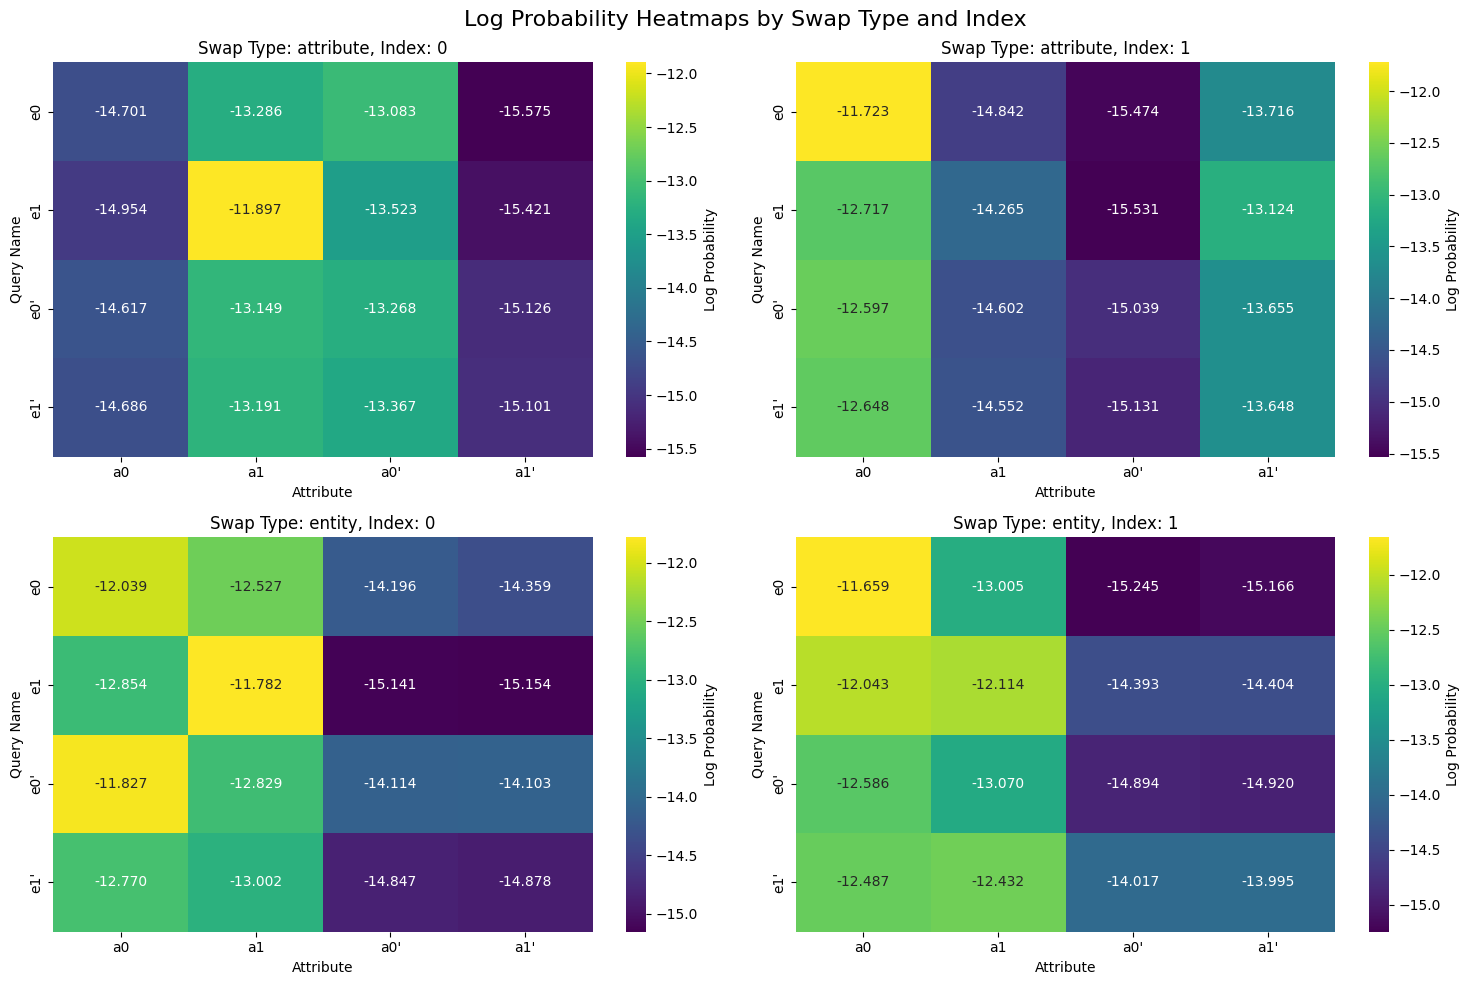

In [13]:
df = pd.read_csv(f"results/{model_alias}/factorizability.csv")
accuracy_df = df.groupby(["query_name", "attribute", "swap_type", "swap_index"]).mean().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for each combination of swap_type and swap_index
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Log Probability Heatmaps by Swap Type and Index', fontsize=16)

# Define the order for consistent plotting
attribute_order = ['a0', 'a1', "a0'", "a1'"]
query_order = ['e0', 'e1', "e0'", "e1'"]

# Get unique combinations of swap_type and swap_index
swap_combinations = accuracy_df[['swap_type', 'swap_index']].drop_duplicates().sort_values(['swap_type', 'swap_index'])

for idx, (_, row) in enumerate(swap_combinations.iterrows()):
    swap_type = row['swap_type']
    swap_index = row['swap_index']
    
    # Filter data for this combination
    subset = accuracy_df[(accuracy_df['swap_type'] == swap_type) & (accuracy_df['swap_index'] == swap_index)]
    
    # Create pivot table for heatmap
    pivot_data = subset.pivot(index='query_name', columns='attribute', values='log_prob')
    
    # Reorder according to specified order
    pivot_data = pivot_data.reindex(index=query_order, columns=attribute_order)
    
    # Determine subplot position
    row_idx = idx // 2
    col_idx = idx % 2
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.3f', 
                cmap='viridis',
                ax=axes[row_idx, col_idx],
                cbar_kws={'label': 'Log Probability'})
    
    axes[row_idx, col_idx].set_title(f'Swap Type: {swap_type}, Index: {swap_index}')
    axes[row_idx, col_idx].set_xlabel('Attribute')
    axes[row_idx, col_idx].set_ylabel('Query Name')

plt.tight_layout()
plt.show()


In [7]:
accuracy_df[(accuracy_df["swap_type"] == "entity") & (accuracy_df["swap_index"] == 0)]

,query_name,attribute,swap_type,swap_index,run,log_prob
2,e0,a0,entity,0,49.5,-0.470668
6,e0,a0',entity,0,49.5,-14.817182
10,e0,a1,entity,0,49.5,-8.970528
14,e0,a1',entity,0,49.5,-15.403906
18,e0',a0,entity,0,49.5,-2.073805
22,e0',a0',entity,0,49.5,-12.030820
26,e0',a1,entity,0,49.5,-4.016923
30,e0',a1',entity,0,49.5,-12.426659
34,e1,a0,entity,0,49.5,-10.305882
38,e1,a0',entity,0,49.5,-16.587479


In [101]:
main_prompt

'Answer the question based on the context below. Keep the answer short.\n\nContext: Jason lives in the capital city of Sweden. Nancy lives in the capital city of Uruguay.\nQuestion: Which city does Jason live in?\nAnswer: Jason lives in the city of'

In [112]:
answer_id = tokenizer(mp.answers[query_entity_idx], add_special_tokens=False)["input_ids"][0]
log_probs = F.log_softmax(modified_out.logits[0,-1,:], dim=-1)
log_probs[answer_id]


tensor(-0.0315, device='cuda:0')

In [110]:
log_probs

tensor([-23.2788, -21.2583, -14.3669,  ..., -23.6564, -24.3424, -25.9400],
       device='cuda:0')

In [45]:
n2_index

12

In [48]:
tokenizer.convert_ids_to_tokens(main_prompt_tokens["input_ids"][0])[main_n2_index]

'▁Mark'

In [ ]:
tokenizer.convert_ids_to_tokens(main_prompt_tokens["input_ids"][0]).index(f"▁{prompt_pair.main_names[0]}")


3

In [25]:
main_hidden_states

tensor([[[-1.3251e-02, -5.2957e-02, -1.0089e-02,  ...,  1.9258e-02,
           7.3705e-03,  2.5430e-02],
         [-3.4841e-02, -7.5956e-02, -1.0159e-02,  ...,  1.0131e-01,
          -3.9658e-03,  2.3802e-02],
         [-2.6152e-02, -5.9799e-02,  2.6138e-02,  ...,  1.2930e-02,
           3.9451e-02,  1.6938e-02],
         ...,
         [-4.5742e-05,  2.1826e-02, -2.1186e-02,  ..., -4.1297e-02,
           4.5158e-03,  2.1583e-02],
         [ 5.7665e-02, -4.2070e-02, -1.5980e-02,  ..., -6.4957e-03,
           3.3395e-02,  1.0812e-02],
         [-1.4484e-02, -2.2502e-02,  3.3836e-02,  ..., -2.8230e-02,
           5.5241e-02,  1.5567e-02]],

        [[-1.6303e-02,  2.0433e-02,  6.8255e-02,  ...,  3.0602e-03,
          -1.9257e-02,  3.2786e-02],
         [-5.5994e-02, -7.8774e-02,  4.2664e-02,  ...,  2.1059e-01,
           5.3005e-02, -3.5130e-02],
         [-7.0046e-02, -2.4076e-02,  1.2887e-01,  ...,  7.8399e-02,
           7.9528e-02,  9.0209e-03],
         ...,
         [-1.5216e-02,  6